<a href="https://colab.research.google.com/github/Patisson4/ML/blob/master/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

Код для расчёта энтропии:

In [88]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()

    return sum(probabilities * -np.log2(probabilities))

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признаков и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три разных критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [89]:
class Node:
    def __init__(self, depth=1, y=()):
        self.depth = depth
        self.y = y
        self.threshold = -1
        self.feature_index = -1
        self.left = None
        self.right = None

In [90]:
class TreeClassifier:
    def __init__(self, max_tree_depth=0, min_object_per_leaf=0, max_leaves_int_tree=0):
        self.root = None
        self.leaves = 1
        self.max_tree_depth = max_tree_depth
        self.min_object_per_leaf = min_object_per_leaf
        self.max_leaves_in_tree = max_leaves_int_tree

    @staticmethod
    def information_gain(r, left, right):
        return entropy(r) - (len(left) / len(r) * entropy(left) +
                             len(right) / len(r) * entropy(right))

    def probabilities(self, y):
        return np.array([len(y[y == y_type]) / len(y) for y_type in np.unique(self.root.y)])

    def stop_criteria(self, node: Node):
        return (node.depth >= self.max_tree_depth) and (self.max_tree_depth != 0) or (
                len(node.y) <= self.min_object_per_leaf) and (self.max_tree_depth != 0) or (
                       self.leaves > self.max_leaves_in_tree) and (self.max_leaves_in_tree != 0) or (
                       len(np.unique(node.y)) == 1)

    def split_node(self, node: Node, X):
        if self.stop_criteria(node):
            return

        max_gain = None
        index = 0
        threshold = 0

        for i in range(X.shape[1]):
            for value in X[:, i]:
                left = node.y[X[:, i] < value]
                right = node.y[X[:, i] >= value]

                if len(left) == 0 or len(right) == 0:
                    continue

                gain = TreeClassifier.information_gain(node.y, left, right)
                if max_gain is None or gain > max_gain:
                    max_gain = gain
                    index = i
                    threshold = value

        node.threshold = threshold
        node.feature_index = index
        node.left = Node(node.depth + 1, node.y[X[:, index] < threshold])
        node.right = Node(node.depth + 1, node.y[X[:, index] >= threshold])

        self.leaves += 1
        self.split_node(node.left, X[X[:, index] < threshold])
        self.split_node(node.right, X[X[:, index] >= threshold])

    def fit(self, X, y):
        self.root = Node(y=y)
        self.leaves = 1
        self.split_node(self.root, X)

    def predict(self, X):
        result = []

        for x in X:
            node = self.root

            while not (node.left is None and node.right is None):
                if x[node.feature_index] <= node.threshold:
                    node = node.left
                else:
                    node = node.right

            result.append(np.argmax(self.probabilities(node.y)))

        return result

0.94


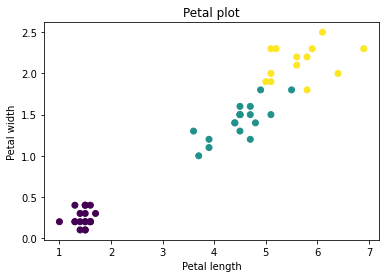

0.94


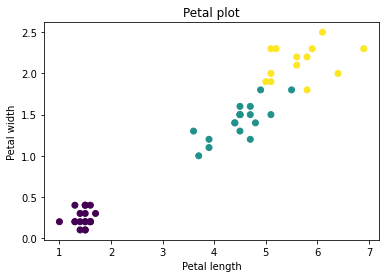

0.94


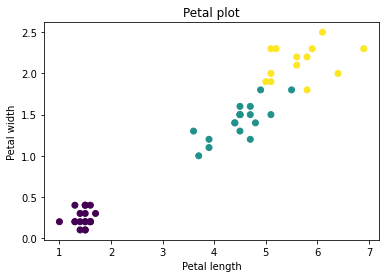

0.94


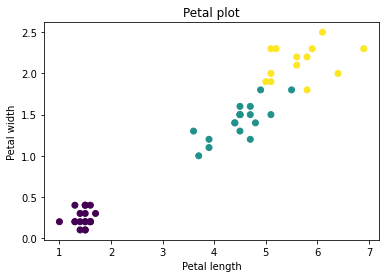

In [91]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


def classify(classifier: TreeClassifier):
    iris = datasets.load_iris()
    X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

    classifier.fit(X_train, y_train)
    y_predicted = classifier.predict(X_test)
    print(accuracy_score(y_test, y_predicted))

    plt.scatter(X_test[:, 2], X_test[:, 3], c=y_predicted)
    plt.title("Petal plot")
    plt.xlabel("Petal length")
    plt.ylabel("Petal width")
    plt.show()


classify(TreeClassifier(max_tree_depth=5))
classify(TreeClassifier(min_object_per_leaf=5))
classify(TreeClassifier(max_leaves_int_tree=5))
classify(TreeClassifier(5, 5, 5))

##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [92]:
!pip install opendatasets
!pip install category_encoders

You should consider upgrading via the 'c:\users\mdpol\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


Using legacy 'setup.py install' for kaggle, since package 'wheel' is not installed.
    Running setup.py install for kaggle: started
    Running setup.py install for kaggle: finished with status 'done'


You should consider upgrading via the 'c:\users\mdpol\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [6]:
import opendatasets as od
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

od.download("https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers?resource=download")
churn_raw = pd.read_csv('churn-for-bank-customers/churn.csv')

churn_raw.head(10)

Skipping, found downloaded files in ".\churn-for-bank-customers" (use force=True to force download)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [ ]:
!pip install category_encoders

In [8]:
from category_encoders import TargetEncoder
from sklearn.tree import DecisionTreeClassifier

churn_target = churn_raw.Exited
churn_raw.Gender = TargetEncoder().fit_transform(churn_raw.Gender, churn_target)
churn_raw.Geography = TargetEncoder().fit_transform(churn_raw.Geography, churn_target)
churn_data = churn_raw.drop(["RowNumber", "Surname", "CustomerId", "Exited"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(churn_data, churn_target, test_size=0.3, random_state=42)

C:\Users\mdpol\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\mdpol\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\mdpol\AppData\Local\Programs\Python\Python310\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will cha

In [9]:
class ForestClassifier:
    def __init__(self, tree_count=100, max_depth=5, min_samples_split=5):
        self.trees = []

        self.tree_count = tree_count
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X_train, y_train):
        k = int(np.sqrt(X_train.shape[1]))

        for i in range(self.tree_count):
            tree = DecisionTreeClassifier(max_features=k, max_depth=self.max_depth,
                                          min_samples_split=self.min_samples_split)
            tree.fit(X_train.sample(n=len(X_train), random_state=i, replace=True), y_train.sample(n=len(y_train), random_state=i, replace=True))

            self.trees.append(tree)

    def predict(self, X_test):
        results = []

        for tree in self.trees:
            results.append(tree.predict(X_test))

        results = pd.DataFrame(data=results)
        return round(results.mean())

    def feature_importance(self):
        results = []

        for tree in self.trees:
            results.append(tree.feature_importances_)

        results = pd.DataFrame(data=results)
        return results.mean()

In [12]:
from time import perf_counter

best_score = 0
best_tree_count = 0
best_max_depth = 0
best_min_samples_split = 0

for tree_count in [100, 250, 500]:
    for max_depth in range(1, 10):
        for min_samples_split in range(2, 5):
            start = perf_counter()
            forest = ForestClassifier(tree_count, max_depth, min_samples_split)
            forest.fit(X_train, y_train)

            predicted = forest.predict(X_test)
            score = accuracy_score(y_test, predicted)

            if score > best_score:
                best_score = score
                best_tree_count = tree_count
                best_max_depth = max_depth
                best_min_samples_split = min_samples_split

            print(f"Performed in {perf_counter() - start}")

Performed in 2.1154184000042733
Performed in 1.9466757999907713
Performed in 1.7028385999728926
Performed in 2.016248400002951
Performed in 2.3120330999954604
Performed in 2.5719269000110216
Performed in 1.9021978999953717
Performed in 1.887314299994614
Performed in 2.0472883000038564
Performed in 2.5724512000160757
Performed in 2.0371756999811623
Performed in 2.1252184999757446
Performed in 2.3920551000046544
Performed in 2.0597488000057638
Performed in 2.003444700007094
Performed in 2.1695050000271294
Performed in 2.2373491000034846
Performed in 2.0950672999897506
Performed in 2.217662200011546
Performed in 2.3156047000084072
Performed in 2.2924225000024308
Performed in 2.315501700009918
Performed in 2.430035500001395
Performed in 2.423625399998855
Performed in 2.3136291000118945
Performed in 2.609066399978474
Performed in 2.5468992999813054
Performed in 4.536816600011662
Performed in 4.590328599995701
Performed in 4.88220839999849
Performed in 4.867527599999448
Performed in 4.874613

In [22]:
print("Лучшие параметры:", f"best_score = {best_score}", f"best_tree_count = {best_tree_count}",
      f"best_max_depth = {best_max_depth}", f"best_min_samples_split = {best_min_samples_split}", sep='\n')

Лучшие параметры:
best_score = 0.8683333333333333
best_tree_count = 500
best_max_depth = 8
best_min_samples_split = 2


In [16]:
random_forest = ForestClassifier(best_tree_count, best_max_depth, best_min_samples_split)
random_forest.fit(X_train, y_train)

predicted = random_forest.predict(X_test)
accuracy_score(y_test, predicted)

0.8666666666666667

In [17]:
pd.DataFrame(data=np.c_[X_test.columns, random_forest.feature_importance()],
             columns=["Feature", "Importance"]).sort_values(
    by="Importance", ascending=False)

,Feature,Importance
3,Age,0.36994
6,NumOfProducts,0.291944
8,IsActiveMember,0.089651
5,Balance,0.079045
1,Geography,0.056669
0,CreditScore,0.038401
9,EstimatedSalary,0.035085
4,Tenure,0.01869
2,Gender,0.016779
7,HasCrCard,0.003795


Самыми важными признаками оказались возраст клиента и количество продуктов